# Задача
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. 

1. Выбрать основную метрику, которую мы планируем прогнозировать. Обосновать, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
2. Построить модель и провалидировать её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определить, для какого горизонта прогнозирования у нас хватает данных.
3. Выбрать ту модель, которая кажется вам наиболее удачной. Проинтерпретировать её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

## Метрика
Будем прогнозировать метрику DAU. Нагрузка на сервера зависит от активности пользователей. Чем больше пользователей у нас ежедневно тем выше будет их активность. Метрика DAU как раз отражает число уникальных пользователей за каждый день. Поэтому возьмем именно ее. \
В качастве данных для прогнозирования возьмем все данные, которые у нас есть, то есть с 3 июня по сегодняшнее число. Метрика считается ежедневно, поэтому у нас будет одно наблюдение за каждый день. \
Регрессоры в нашей модели использовать не будем. Потому что, чтобы ими воспользоваться нам надо будет предсказывать значения этих регрессоров. Мы хотим сдлеать прогноз на месяц вперед, а у нас есть данные за неполные два месяца. если сначала предсказывать регрессоры, а потом по ним предсказывать DAU, то результат может быть хуже, чем если просто предсказывать DAU.

In [2]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.metrics import rmsse
import pandas as pd
import pandahouse as ph

In [169]:
# Выгружаем данные по нашей метрике. Последний день исключаем так за него нет полных данных.

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT toStartOfDay(toDateTime(date)) AS day,
       unique_users AS dau
FROM
  (select date(time) as date,
          count(distinct user_id) as unique_users
   from simulator_20230720.feed_actions a
   full join simulator_20230720.message_actions b using (user_id)
   group by date(time)) AS virtual_table
GROUP BY day, dau
ORDER BY day
'''

activity = ph.read_clickhouse(query=query, connection=connection)
activity.drop(labels = [57, 58],axis = 0, inplace = True)
activity.head()

,day,dau
0,2023-06-03,878
1,2023-06-04,2238
2,2023-06-05,3105
3,2023-06-06,3721
4,2023-06-07,4617


## Построение модели

Сравним две модели одна с импользованием MAP, вторая с использованием MCMC. \
Для бэккастинга у нас не хватит данных. Так как мы хотим прогнозировать на месяц вперед, а у нас еcть данные за неполных два месяца. То есть если бы взяли начальное окно в месяц и прогнозировали бы еще на месяц вперед, то у нас не хватило бы данных даже на две итерации. Если бы наш горизонт прогнозирования был равен неделе, тогда бы смогли сделать бэккастинг. \
Поэтому разобьем наши данные на тесовую и тренировочную выборки. Тренирвочной выборкой будут почти все данные за июнь, а тестовой оставшиеся 30 дней.

In [158]:
train_dat = activity.query("day < '2023-06-30'") #возьмём часть данных для обучения
test_dat = activity.query("day>= '2023-06-30'").astype({"num_posts":"int64"}) ## тестировать будем на 30 днях

### MCMC

2023-07-30 09:39:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1500 and samples(per chain): 750.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

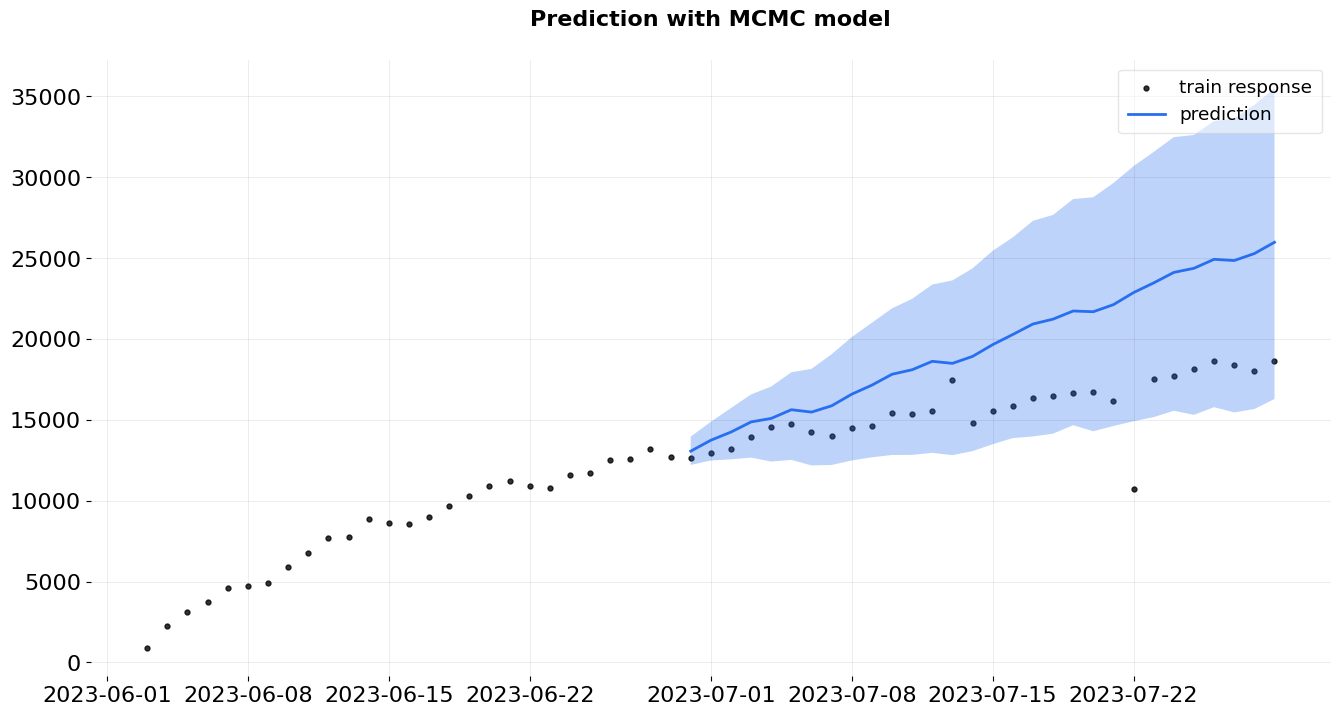

In [184]:
# Строим модель
model_mcmc = DLT(seasonality=7, response_col="dau", date_col="day", 
               estimator='stan-mcmc', 
               num_warmup=6000, 
               num_sample=3000) 

# Обучаем
model_mcmc.fit(train_dat)

# Строим предсказание
predicted_df_mcmc = model_mcmc.predict(df=test_dat)

#Визуализируем
_ = plot_predicted_data(activity, predicted_df_mcmc, "day", 'dau', title='Prediction with MCMC model')

## MAP

2023-07-30 09:40:39 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

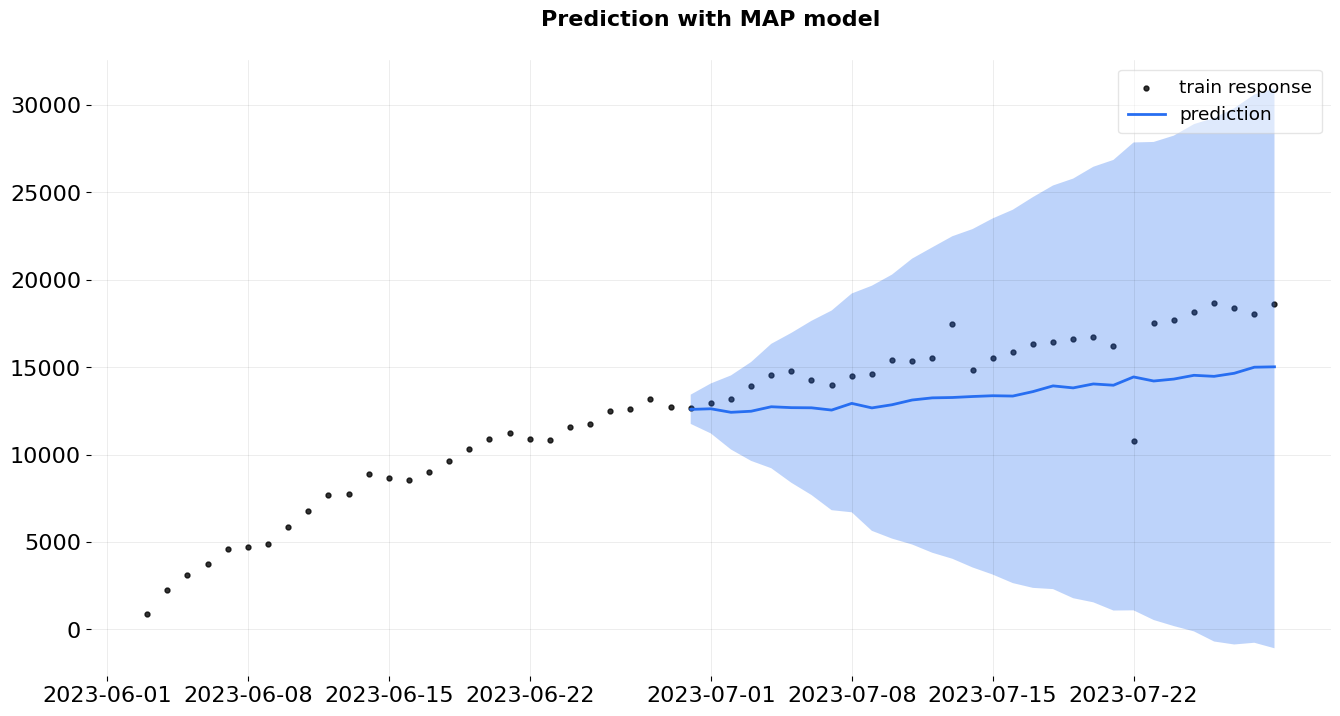

In [186]:
model_map = DLT(response_col="dau",
                date_col="day", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=5000
               ) 

model_map.fit(train_dat)

predicted_df_map = model_map.predict(df=test_dat)

_ = plot_predicted_data(activity, predicted_df_map, "day", 'dau', title='Prediction with MAP model') 

In [185]:
# Сравним модели по RMSSE
print(f"map: {rmsse(test_dat.dau.values, predicted_df_map.prediction.values, train_dat.dau.values)}")
print(f"mcmc: {rmsse(test_dat.dau.values, predicted_df_mcmc.prediction.values, train_dat.dau.values)}")

map: 1.4817936145026211
mcmc: 2.690675559930283


В результате мы видим, что модель MAP лучше предсказывает DAU, хотя имеет больший доверительный интервал. Это можно увидеть визуально на графиках и метрика RMSSE это также подтверждает. Поэтому выберем модель на основе MAP.

## Прогноз

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

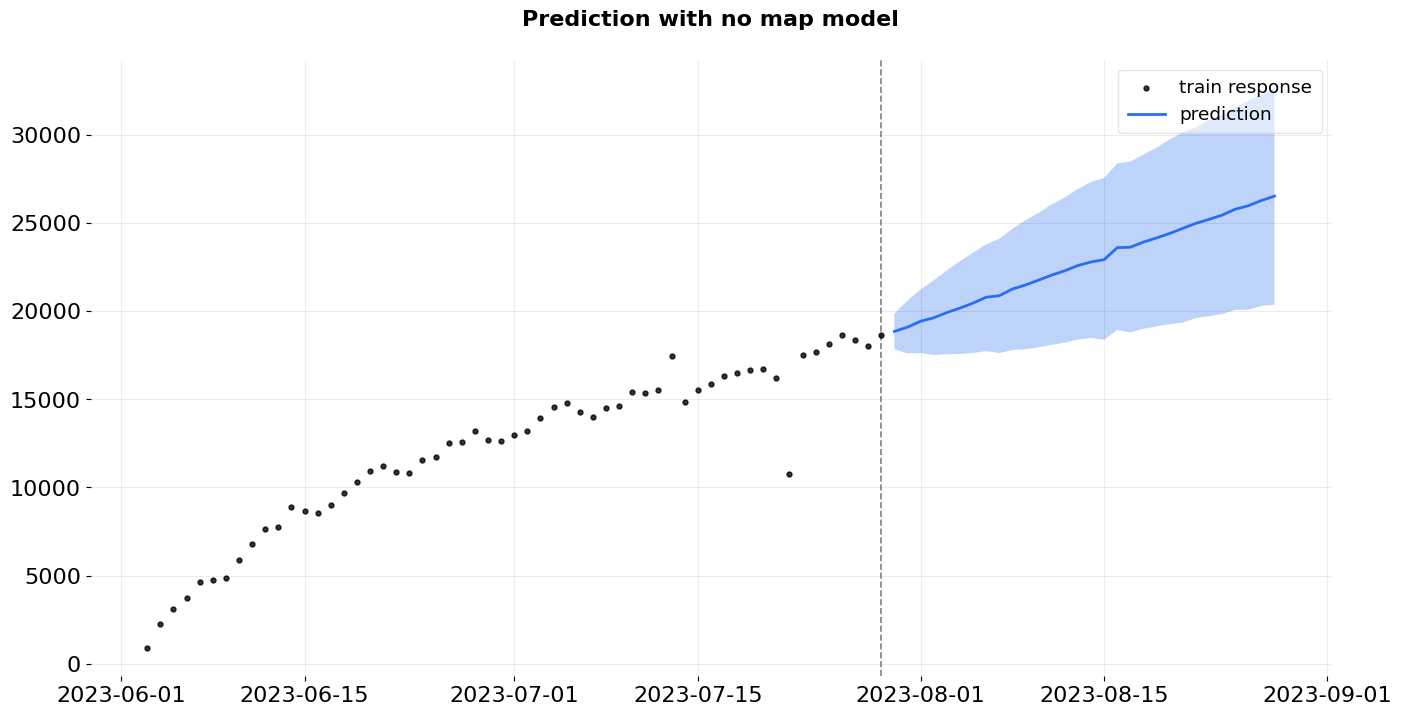

In [188]:
# Обучаем
model_map.fit(activity)

# Строим предсказание
future_df = model_map.make_future_df(periods=30)

predicted_df = model_map.predict(df=future_df)

#Визуализируем
_ = plot_predicted_data(activity, predicted_df, "day", 'dau', title='Prediction with no map model')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

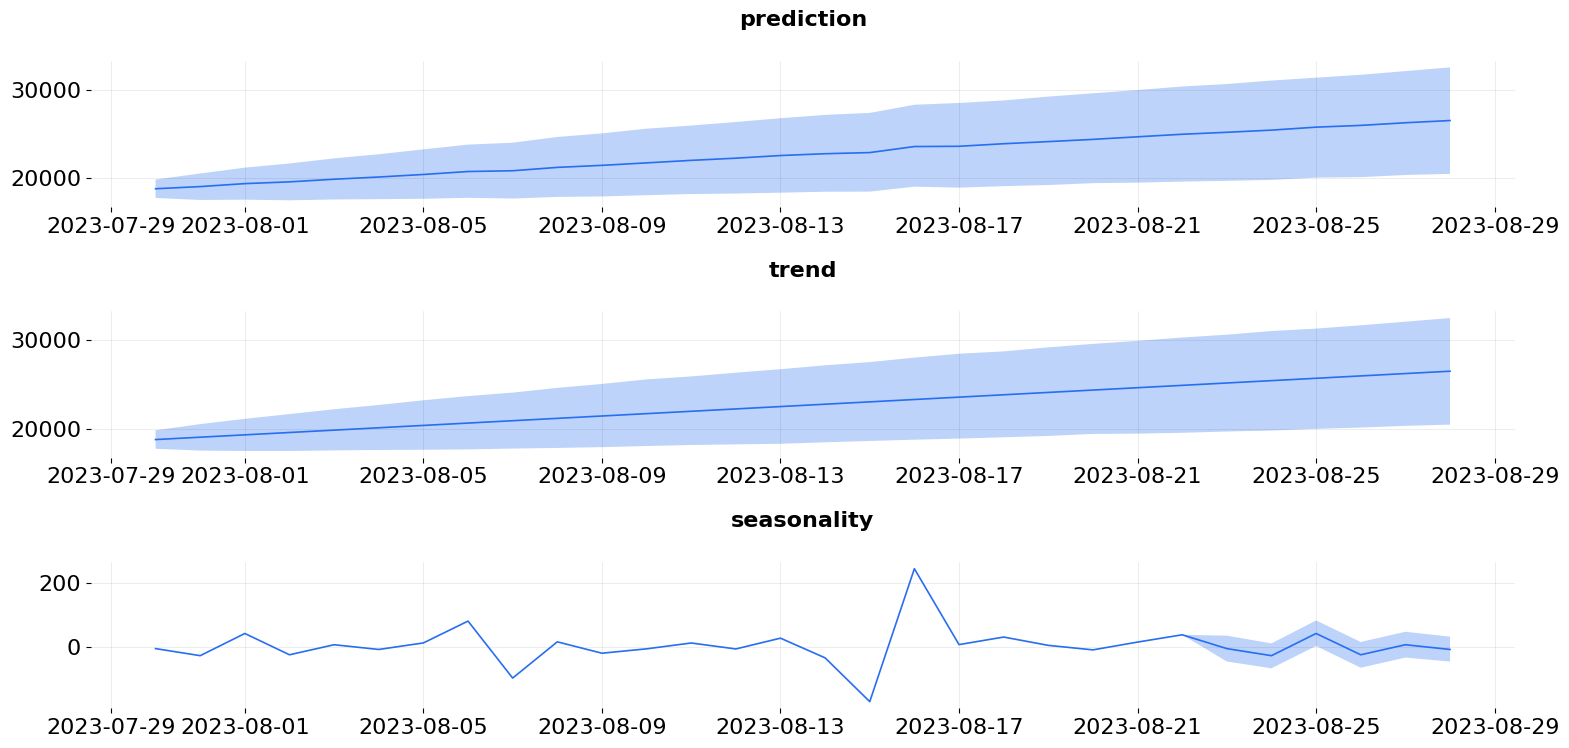

In [189]:
# Декомпозируем
predicted_df = model_map.predict(df=future_df, decompose=True)

_ = plot_predicted_components(predicted_df, "day", plot_components=['prediction', 'trend', 'seasonality'])

## Вывод

В нашем прогнозе виден явный положительный тренд. Через месяц метрика DAU дойдет примерно до 26000 пользователей. Поэтому нужно увеличивать мощность серверов, чтобы не было подвисаний.